# Creación de Modelo para Reconocer Emociones en Palabras

El fin de este proyecto es generar una red neuronal que pueda reconocer emociones en el habla a partir de palabras específicas.
Puesto que el análisis de las emociones en las frases es tema complejo y con muchos frentes de dónde abordar, el propuesto aquí ***considera la premisa de la existencia de palabras con mayor relevancia emocional en una frase que otras***.

Por el momento se trabajará solamente con MESD, pero se plaena añadir EmoSpanishDB.

In [ ]:
!pip install librosa --upgrade


In [ ]:
import keras
print(keras.__version__)

2.15.0


## Preparación de datos
---

In [ ]:
# Importar base de datos
from google.colab import drive
import zipfile

drive.mount('/content/drive') # nos unimos a la nube de drive

#Path de los archivos zip
zip_MESD =    '/content/drive/MyDrive/MESD.zip'
zip_ref = zipfile.ZipFile(zip_MESD,'r')
zip_ref.extractall('/content/MESD')
zip_ref.close()
!ls

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive
drive  MESD  sample_data


In [ ]:
from ast import pattern
import pandas as pd
import os

pattern_path = '/content/MESD/Mexican Emotional Speech Database (MESD)'
file_names = os.listdir(pattern_path)
print(len(file_names))

dataset = {'audio':[],'emotion':[]}
for name in file_names:
  dataset['emotion'].append(name.split('_')[0])
  dataset['audio'].append(os.path.join(pattern_path,name))
print(dataset)
print(len(dataset['audio']))
print(len(dataset['audio']))

862
{'audio': ['/content/MESD/Mexican Emotional Speech Database (MESD)/Fear_F_B_explosivo.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Happiness_M_A_abajo.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_C_A_dentro.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Anger_C_A_hola.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_F_A_no.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_C_A_arriba.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_M_B_dificultad.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Neutral_F_A_arriba.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Neutral_C_A_nunca.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Disgust_C_A_rapido.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_M_B_estafa.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Disgust_C_A_hoy.wav', '/content/MESD/Mexic

In [ ]:
df = pd.DataFrame(dataset)
df.head()

,audio,emotion
0,/content/MESD/Mexican Emotional Speech Databas...,Fear
1,/content/MESD/Mexican Emotional Speech Databas...,Happiness
2,/content/MESD/Mexican Emotional Speech Databas...,Sadness
3,/content/MESD/Mexican Emotional Speech Databas...,Anger
4,/content/MESD/Mexican Emotional Speech Databas...,Sadness


<Axes: xlabel='emotion', ylabel='count'>

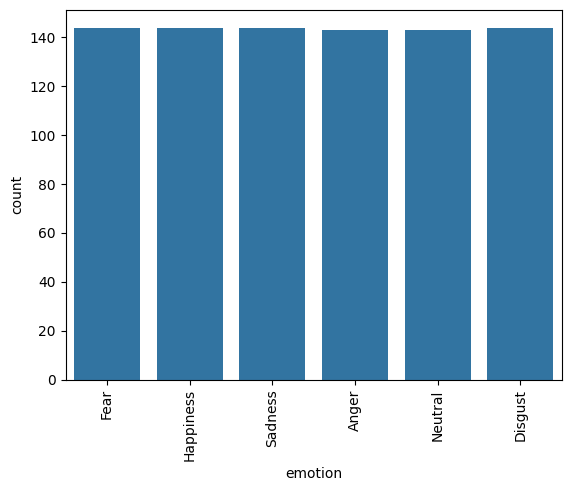

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xticks(rotation='vertical')
sns.countplot(x=df['emotion'])

## **Paso 1. Cargar audios**

In [ ]:
sampling_rate =16000

In [ ]:
import librosa

def load(data_path, sr=sampling_rate):
  dataset = {'audio':[], 'emotion':[]}
  # terar sobre cada archivo
  for i in range (len(data_path)):
    # Guardar la ruta y la emoción
    audio_path = data_path['audio'][i]
    emotion = data_path['emotion'][i]
    # cargar
    sound,sr = librosa.load(audio_path,sr=sr)
    dataset['audio'].append(sound)
    dataset['emotion'].append(emotion)
  return dataset

In [ ]:
dataset = load(df)

In [ ]:
print(len(dataset['emotion']))

862


**Revisión previa de longitud de audio**

In [ ]:
def get_average_length(ds):
  total_length = 0
  num_audios = len(ds['audio'])

  for audio in ds['audio']:
    audio_length = len(audio)
    total_length += audio_length

  average_length = total_length/num_audios
  return int(average_length)

In [ ]:
average_length = get_average_length(dataset)
print(f'Average length: ', average_length)

Average length:  11562


In [ ]:
contador = 0
for i,audio in enumerate(dataset['audio']):
  length = len(audio)
  if length > 23000:
    print(str(length) + ' --> ' + str((dataset['emotion'][i])) + ' --> ' + str(i))
    contador +=1
print(contador)

40595 --> Happiness --> 47
34912 --> Happiness --> 66
29697 --> Happiness --> 73
32378 --> Happiness --> 214
31533 --> Happiness --> 245
26682 --> Happiness --> 301
29489 --> Happiness --> 322
34939 --> Happiness --> 326
29182 --> Happiness --> 398
34377 --> Happiness --> 408
31613 --> Happiness --> 449
32165 --> Happiness --> 454
29615 --> Happiness --> 484
29697 --> Happiness --> 583
32722 --> Happiness --> 598
32331 --> Happiness --> 654
28519 --> Happiness --> 679
35877 --> Happiness --> 694
27765 --> Happiness --> 743
37308 --> Happiness --> 754
29697 --> Happiness --> 787
35036 --> Happiness --> 820
28242 --> Happiness --> 849
23


## **Paso 2. Separar por clases al dataset**

In [ ]:
def get_dataset_class(ds, target_label):
  dataset_class = {'audio':[], 'emotion':[]}

  for i,audio in enumerate(ds['audio']):
    if ds['emotion'][i] == target_label:
      dataset_class['audio'].append(audio)
      dataset_class['emotion'].append(target_label)

  print(str(target_label) + (' --> ') + str(len(dataset_class['emotion'])))
  return dataset_class

In [ ]:
label_emotions = ['Anger', 'Happiness', 'Disgust', 'Neutral', 'Sadness', 'Fear']
anger_ds = get_dataset_class(dataset, label_emotions[0])
happiness_ds = get_dataset_class(dataset, label_emotions[1])
disgust_ds = get_dataset_class(dataset, label_emotions[2])
neutral_ds = get_dataset_class(dataset, label_emotions[3])
sadness_ds = get_dataset_class(dataset, label_emotions[4])
fear_ds = get_dataset_class(dataset, label_emotions[5])

Anger --> 143
Happiness --> 144
Disgust --> 144
Neutral --> 143
Sadness --> 144
Fear --> 144


## **Paso 3. Data augmentation**

Se realizará un 100% de data augmentation divido en tres métodos. Es decir, 48 muestras extras por cada método en cada clase

**Display random samples**

In [ ]:
from IPython.display import Audio

def display_random_sample(ds, emotion='emotion', sampling_rate=sampling_rate):
  random_index = np.random.choice(len(ds['emotion']))
  print(f'índice: ', random_index)
  emotion = ds['emotion'][random_index]
  audio = ds['audio'][random_index]
  plt.figure(figsize=(8,4))
  librosa.display.waveshow(audio,sr=sampling_rate)
  plt.title(f'Waveform for emotion {emotion}')
  plt.xlabel('Tie (s)')
  plt.ylabel('Amplitude')
  plt.show()
  display(Audio(audio,rate=sampling_rate))

def display_sample(audio,title='Sample', sampling_rate=sampling_rate):
  plt.figure(figsize=(8,4))
  librosa.display.waveshow(audio,sr=sampling_rate)
  plt.title(title)
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  display(Audio(audio,rate=sampling_rate))

In [ ]:
import numpy as np

# agregar al dataset
def add_to_dataset(dsf):
  global dataset
  print('Antes:', len(dataset['audio']))
  for i in range(len(dsf['emotion'])):
    dataset['emotion'].append(dsf['emotion'][i])
    dataset['audio'].append(dsf['audio'][i])
  print('Después', len(dataset['audio']))

# 1. N O I S E   A D D I T I O N
# El ruido se basa en la desviación estándar del audio
def noise(ds, indices = (0,48), noise_factor=0.070):
  print('--- Noise addition ---')
  noise_dataset = {'audio':[],'emotion':[]}
  indices = np.arange(indices[0],indices[1],1)
  print(indices)
  emotions = [ds['emotion'][i] for i in indices]
  audios = [ds['audio'][i] for i in indices]

  for i in range(len(audios)):
    noise = np.random.normal(0,audios[i].std(), audios[i].size)
    augmented_signal = audios[i]+(noise*noise_factor)

    noise_dataset['emotion'].append(emotions[i])
    noise_dataset['audio'].append(augmented_signal)

  print(len(noise_dataset['audio']))
  display_sample(ds['audio'][indices[0]], title='Original')
  display_sample(noise_dataset['audio'][0], title='Noise addition')

  add_to_dataset(noise_dataset)

# 2. P I T C H   S H I F T I N G
def pitch_shift(ds,indices=(0,48),sr=sampling_rate,min_pitch=-4,max_pitch=4):
  print('--- Pitch-Shifting addition ---')
  ps_dataset = {'audio':[], 'emotion':[]}

  indices = np.arange(indices[0],indices[1],1)
  emotions = [ds['emotion'][i] for i in indices]
  audios = [ds['audio'][i] for i in indices]

  for i in range(len(audios)):
    pitch_shift_factor = np.random.uniform(min_pitch,max_pitch)
    pitch_shifted_audio = librosa.effects.pitch_shift(audios[i],sr=sr,
                                          n_steps=pitch_shift_factor)
    ps_dataset['audio'].append(pitch_shifted_audio)
    ps_dataset['emotion'].append(emotions[i])

  print(len(ps_dataset['audio']))
  display_sample(ds['audio'][indices[0]], title='Original')
  display_sample(ps_dataset['audio'][0], title='Noise addition')

  add_to_dataset(ps_dataset)

# 3. T I M E   S T R E T C H I N G
# Utilizaremos 'time_stretching con factor variable
def time_stretching(ds,indices=(0,48),sr=sampling_rate):
  print('--- Time Stretching addition ---')
  ts_dataset = {'audio':[],'emotion':[]}
  indices = np.arange(indices[0],indices[1],1)
  emotions = [ds['emotion'][i] for i in indices]
  audios = [ds['audio'][i] for i in indices]

  for i in range(len(audios)):
    stretch_factor = np.random.uniform(0.6,1.2)
    audio_stretch = librosa.effects.time_stretch(audios[i],rate=stretch_factor)

    ts_dataset['audio'].append(audio_stretch)
    ts_dataset['emotion'].append(emotions[i])

  display_sample(ds['audio'][indices[0]], title='Original')
  display_sample(ts_dataset['audio'][0], title='Noise addition')

  print(len(ts_dataset['audio']))
  add_to_dataset(ts_dataset)


In [ ]:
def data_augmentation(ds, num_audios, step, last_offset=False):
  noise(ds, indices = (0,step))
  pitch_shift(ds, indices=(step,step+step))

  if last_offset == True:
    indices = ((step+step-2),(step+(step*2))-1)
    print(indices)
    time_stretching(ds,indices=indices)
  else:
    time_stretching(ds, indices=(step+step, (step+(step*2))))

--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 862
Después 910
--- Pitch-Shifting addition ---
48


Antes: 910
Después 958
(94, 143)
--- Time Stretching addition ---


49
Antes: 958
Después 1007
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1007
Después 1055
--- Pitch-Shifting addition ---
48


Antes: 1055
Después 1103
--- Time Stretching addition ---


48
Antes: 1103
Después 1151
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1151
Después 1199
--- Pitch-Shifting addition ---
48


Antes: 1199
Después 1247
--- Time Stretching addition ---


48
Antes: 1247
Después 1295
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1295
Después 1343
--- Pitch-Shifting addition ---
48


Antes: 1343
Después 1391
(94, 143)
--- Time Stretching addition ---


49
Antes: 1391
Después 1440
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1440
Después 1488
--- Pitch-Shifting addition ---
48


Antes: 1488
Después 1536
--- Time Stretching addition ---


48
Antes: 1536
Después 1584
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1584
Después 1632
--- Pitch-Shifting addition ---
48


Antes: 1632
Después 1680
--- Time Stretching addition ---


48
Antes: 1680
Después 1728


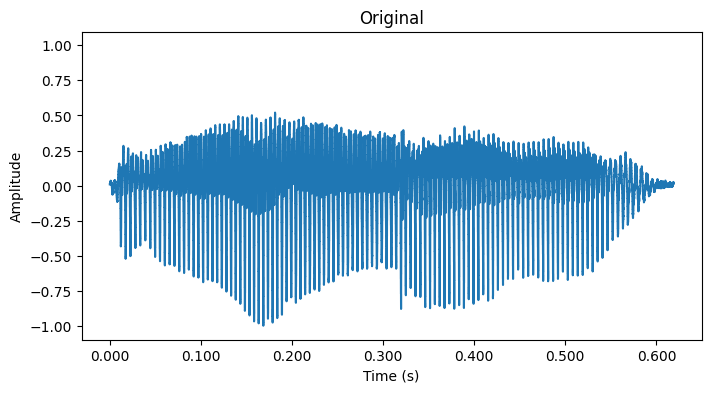

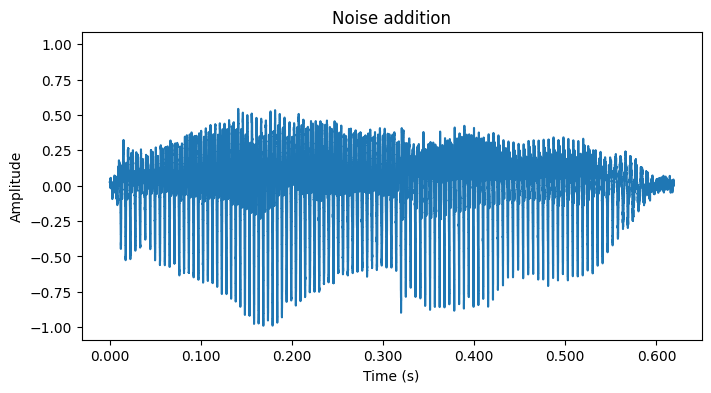

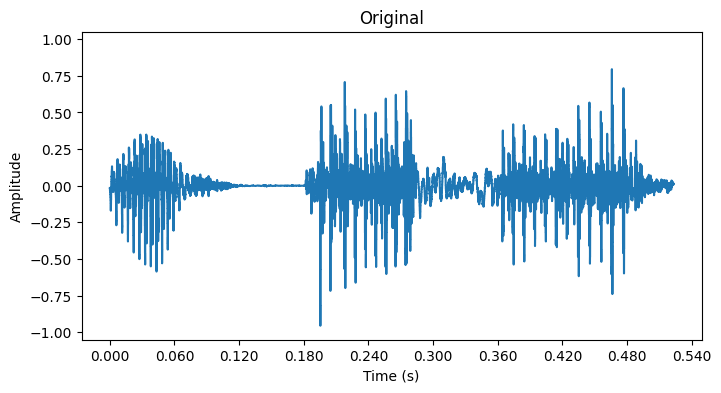

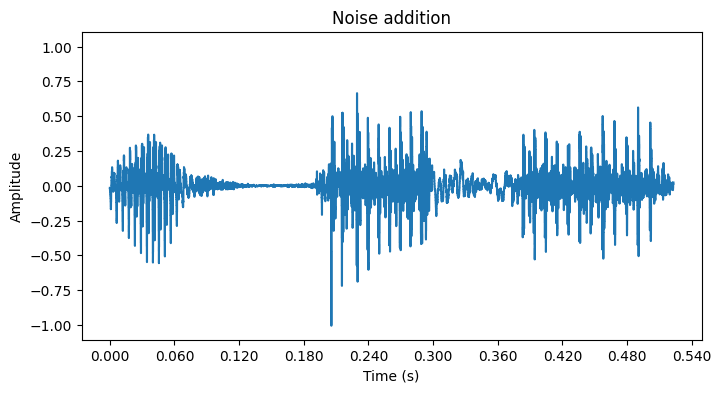

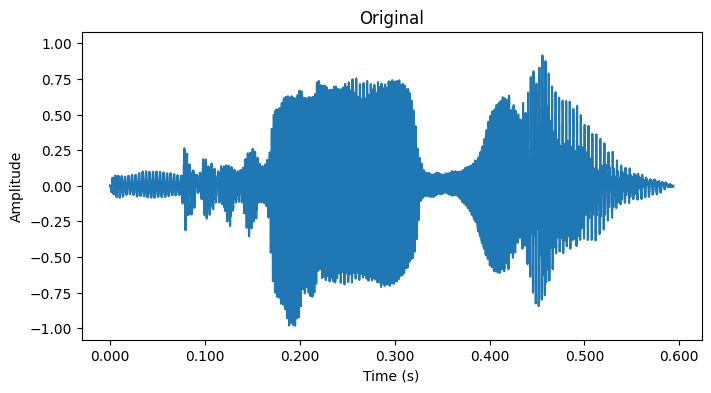

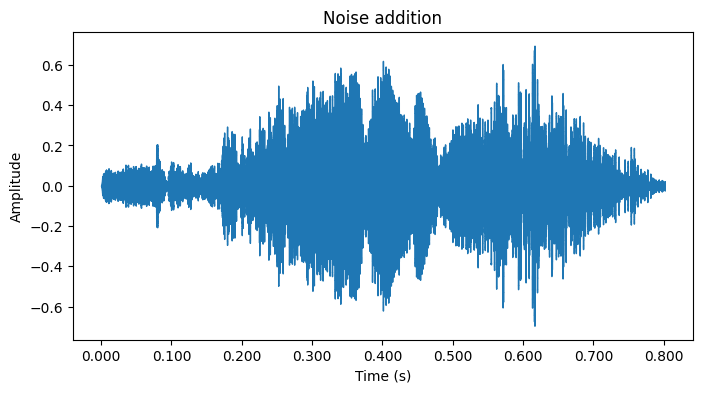

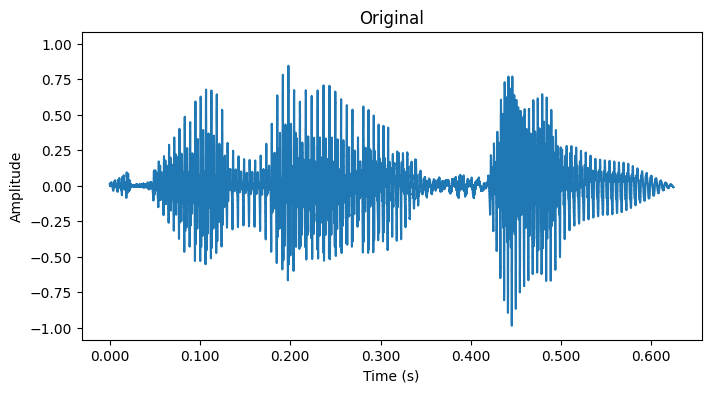

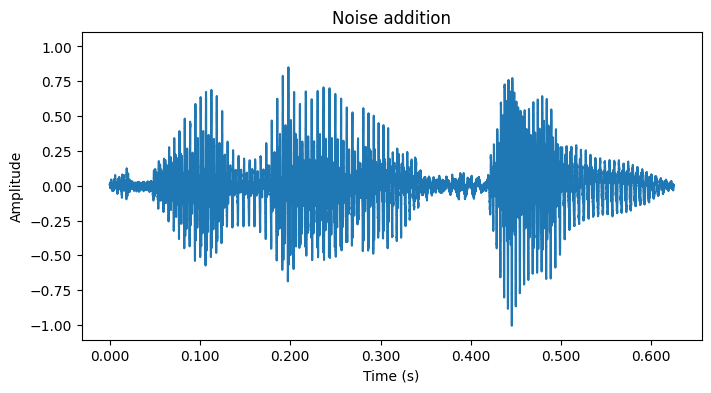

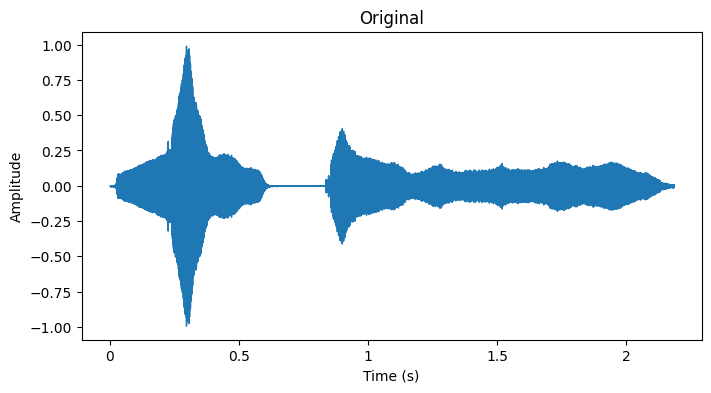

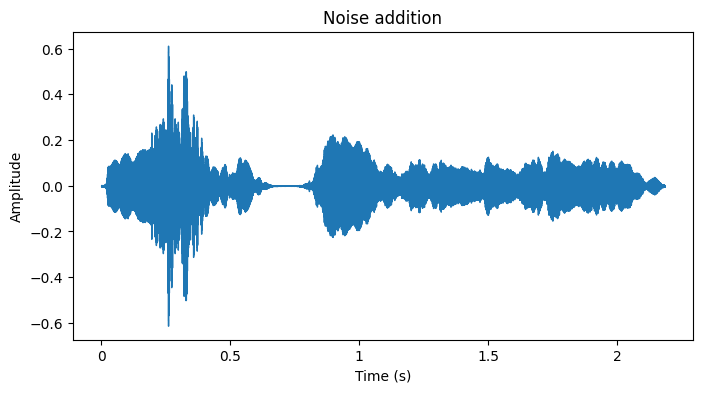

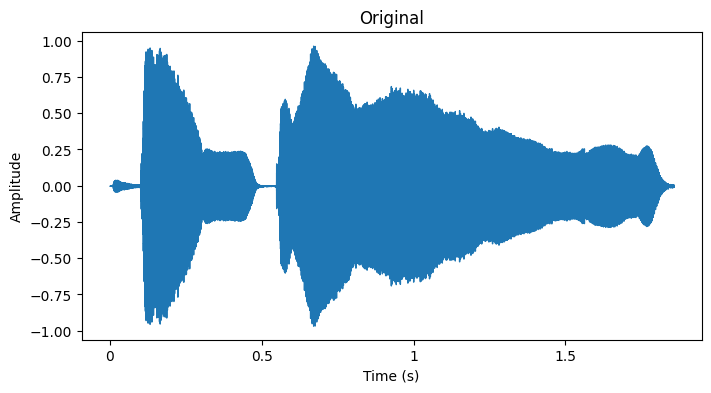

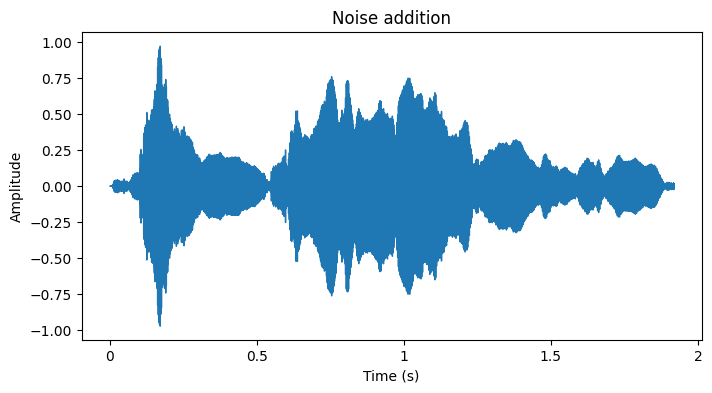

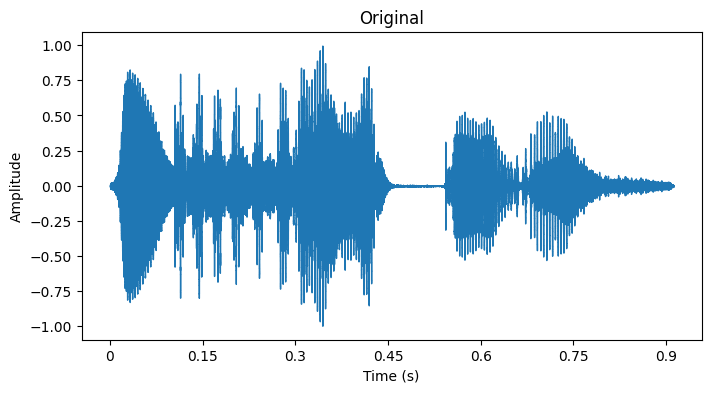

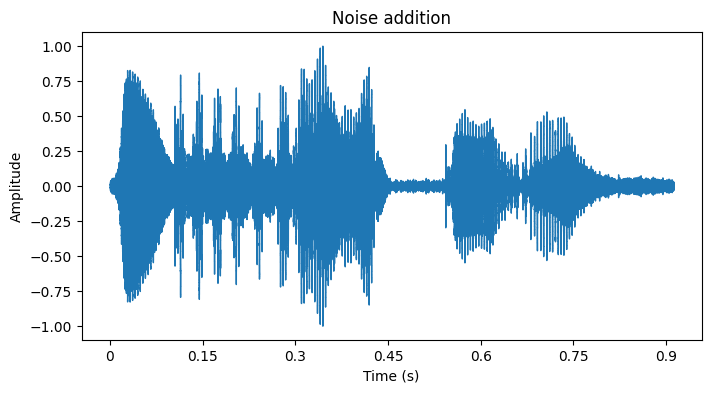

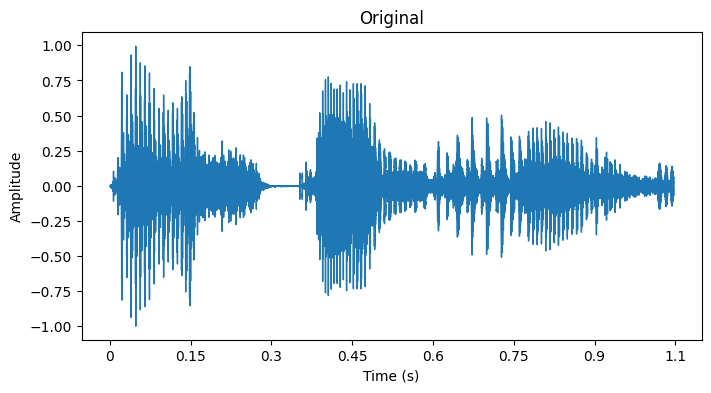

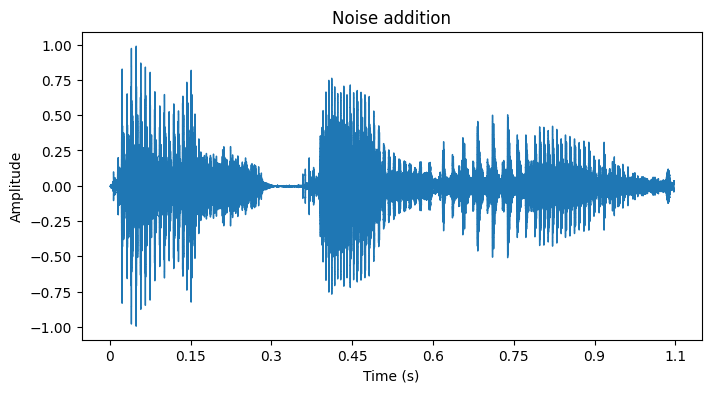

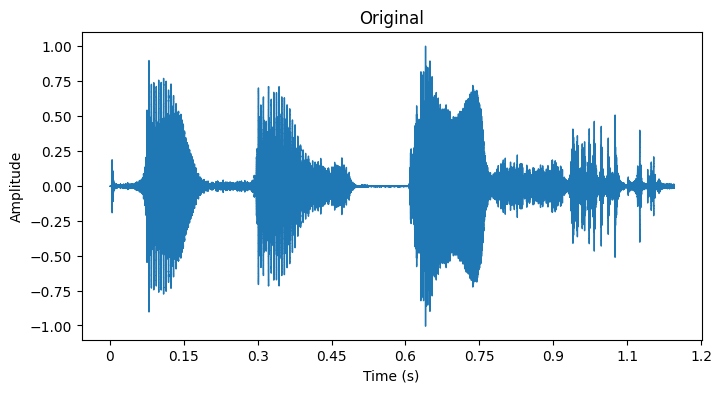

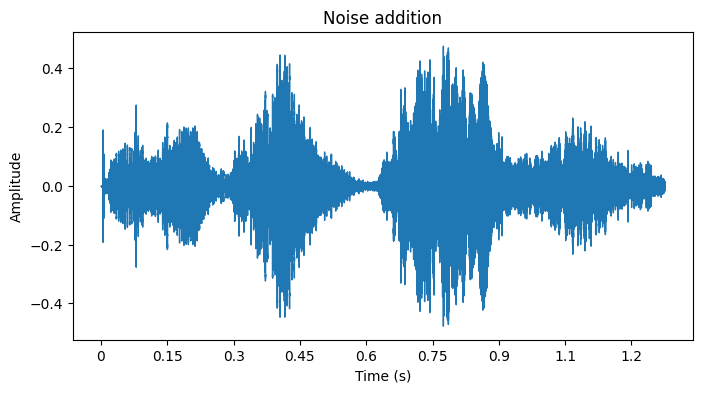

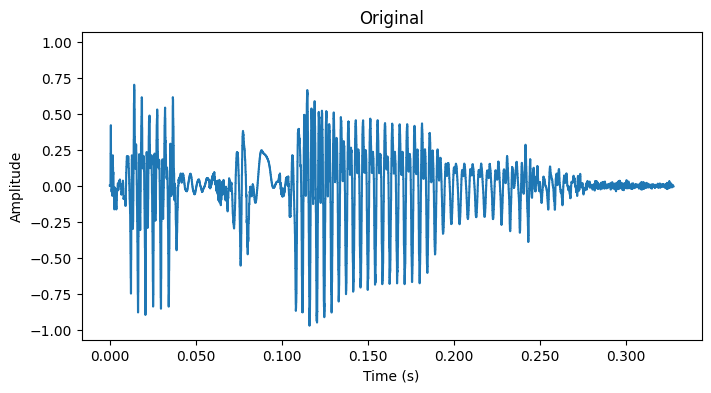

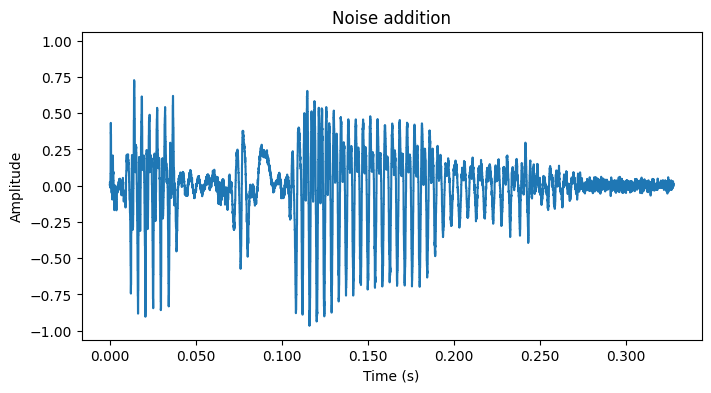

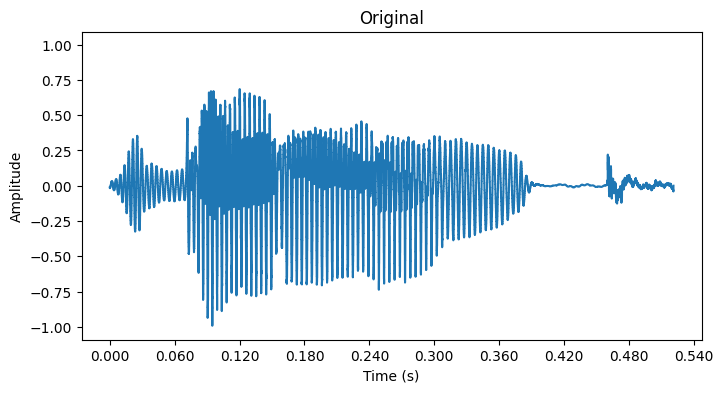

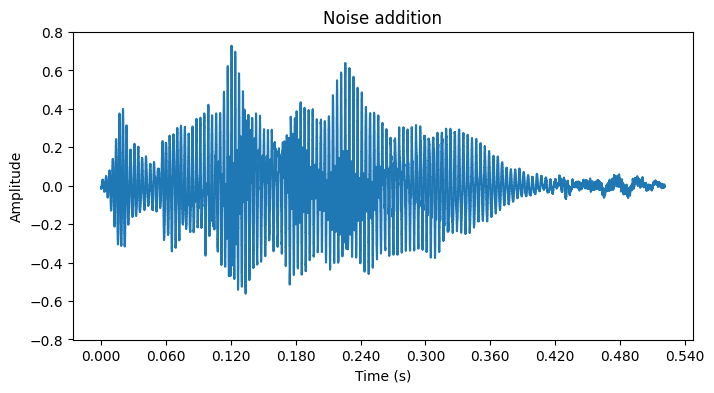

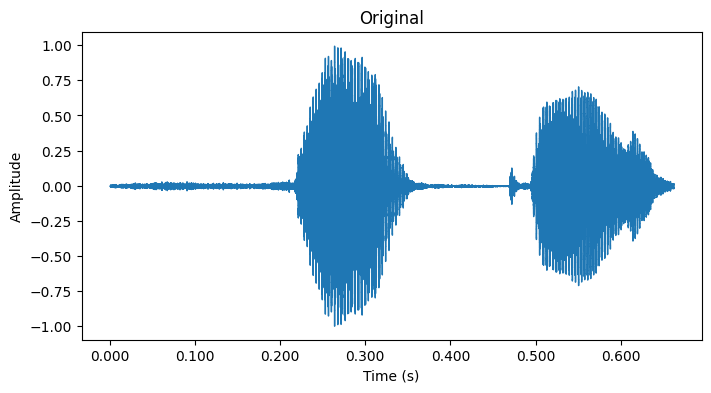

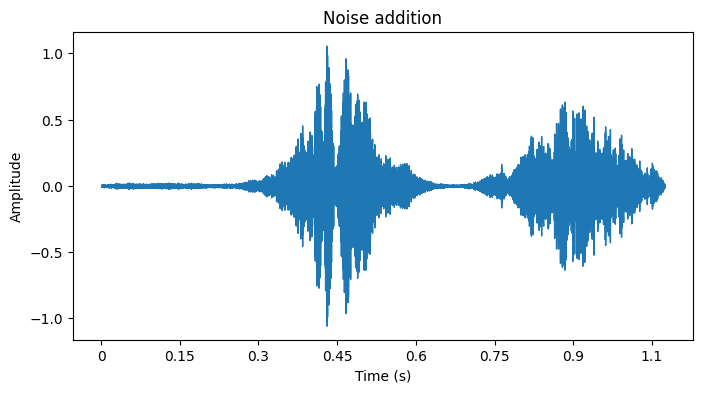

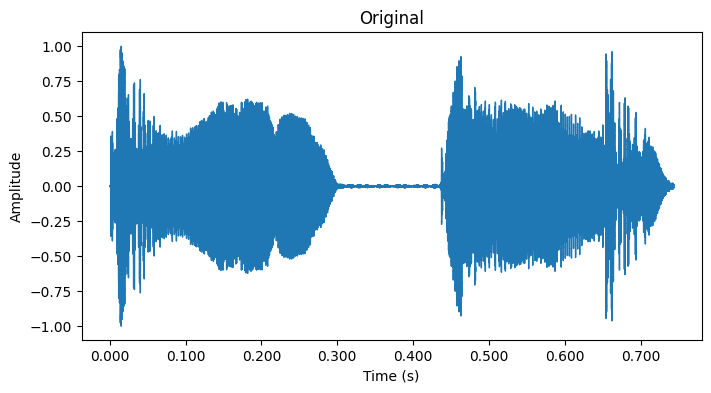

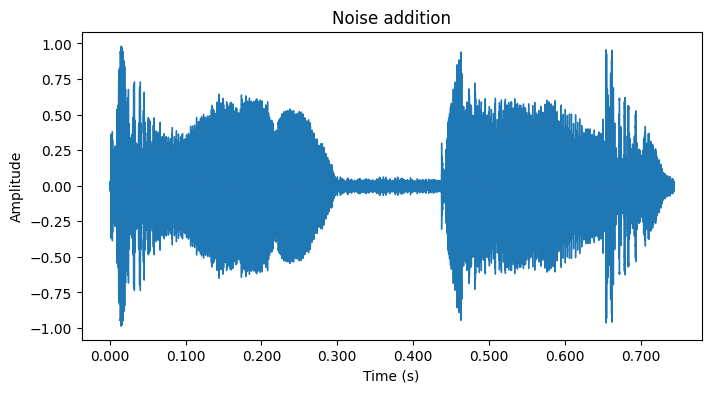

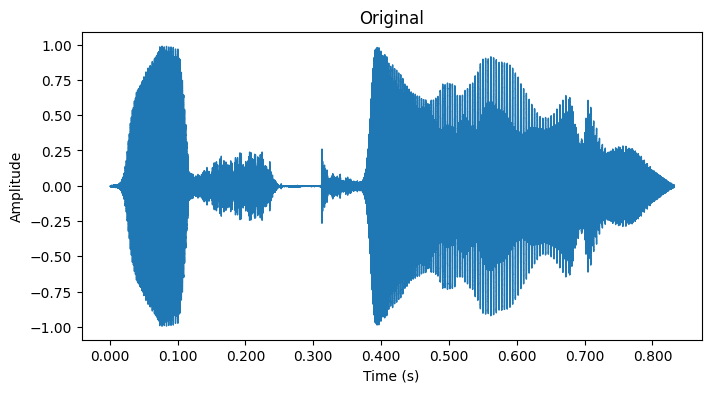

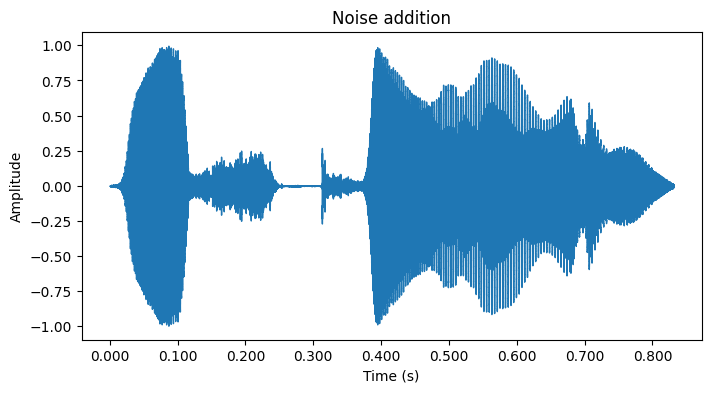

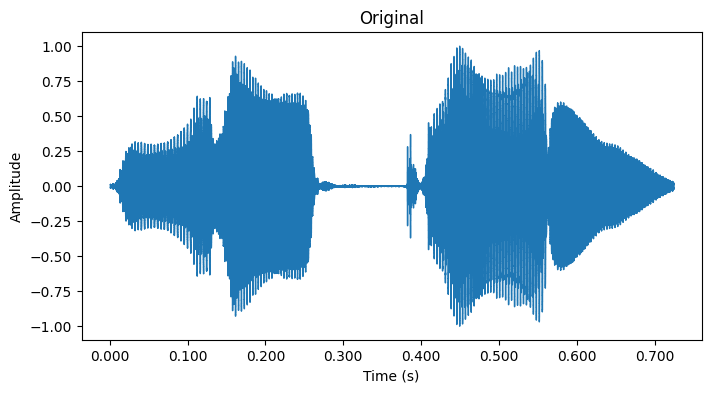

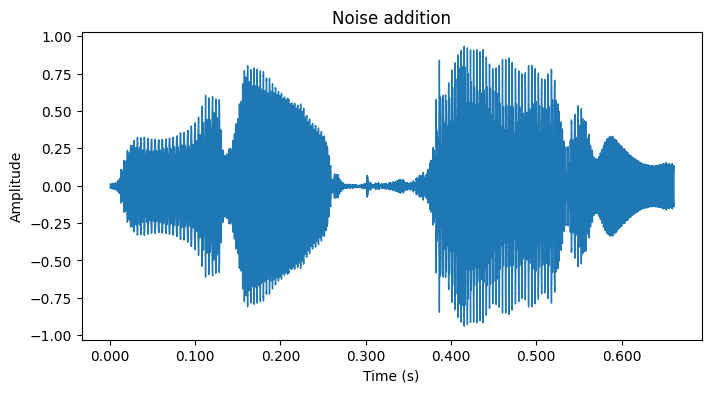

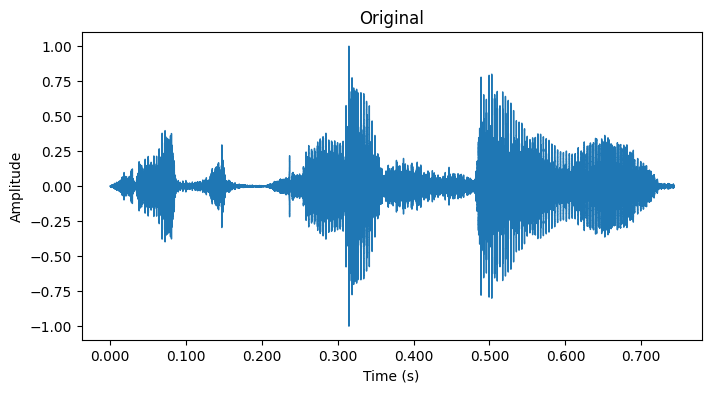

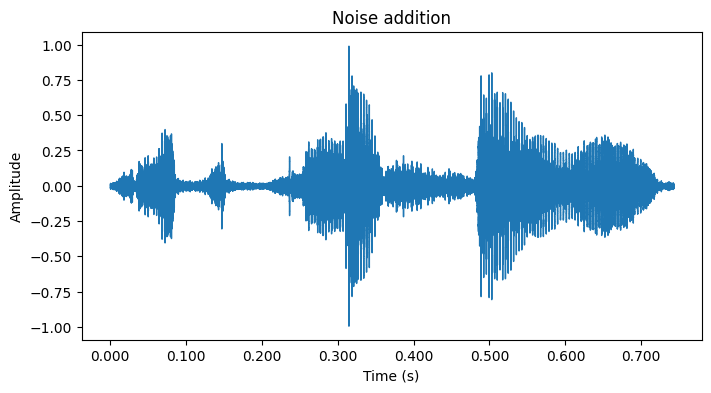

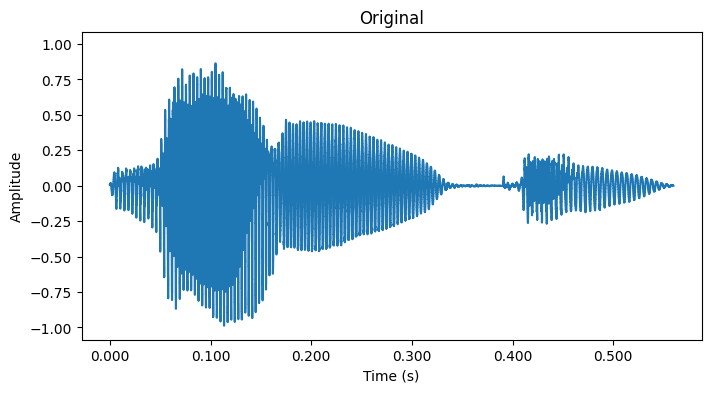

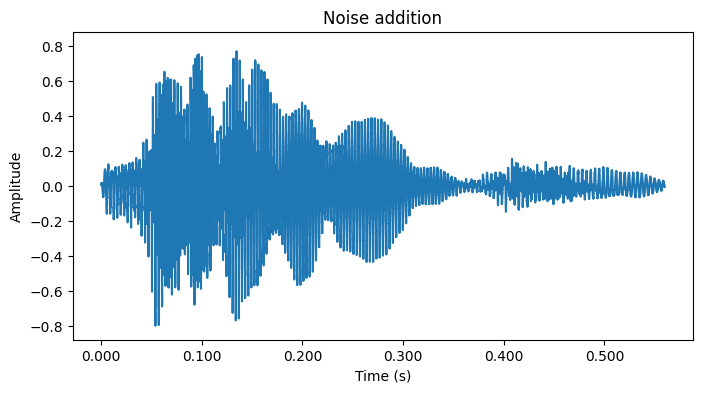

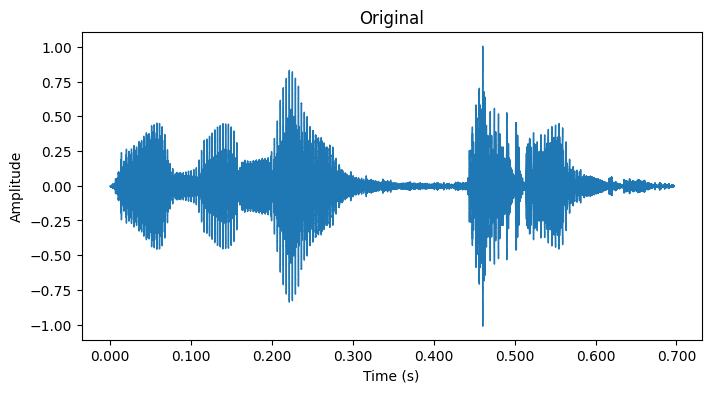

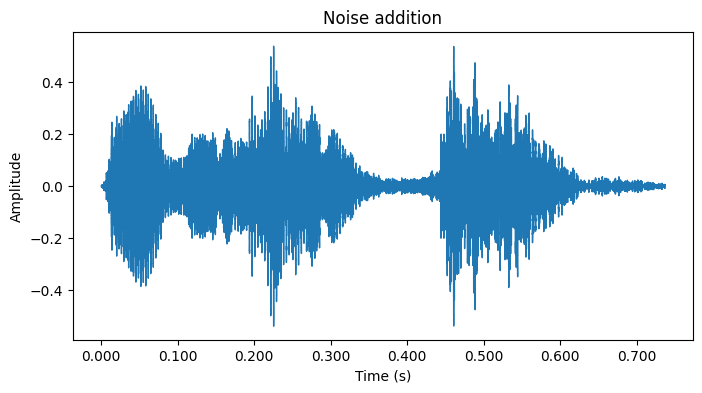

In [ ]:
data_augmentation(anger_ds,148,48, last_offset=True)
data_augmentation(happiness_ds,148,48)
data_augmentation(disgust_ds,148,48)
data_augmentation(neutral_ds,148,48, last_offset=True)
data_augmentation(sadness_ds,148,48)
data_augmentation(fear_ds,148,48)


<Axes: ylabel='count'>

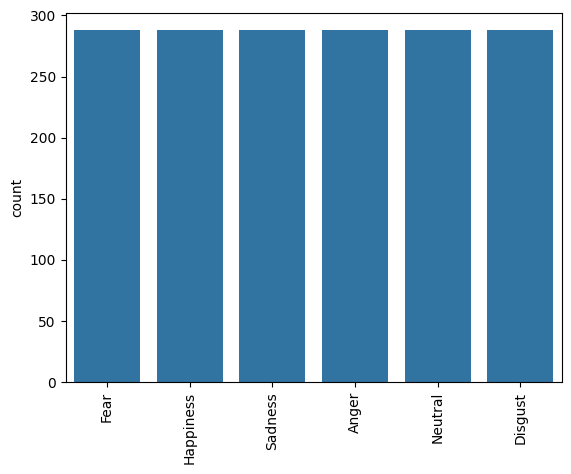

In [ ]:
plt.xticks(rotation='vertical')
sns.countplot(x=dataset['emotion'])

## **Paso 4. Normalizar tamaño de audios**

Dado que se trata de palabras, se normalizarán todos al tamaño máximo que existe.

In [ ]:
def get_average_length(ds):
  total_length = 0
  num_audios = len(ds['audio'])

  for audio in ds['audio']:
    audio_length = len(audio)
    total_length += audio_length

  average_length = total_length/num_audios
  return int(average_length)

In [ ]:
average_length = get_average_length(dataset)
print(f'Average length: ', average_length)

Average length:  11866


In [ ]:
def get_longer_audio(ds):
  lengths = [len(audio) for audio in ds['audio']]
  longer_length = max(lengths)
  return longer_length

In [ ]:
longer_length = get_longer_audio(dataset)
print(longer_length)

50698


**Al parecer hay mucha desviación.**
Se tratará de obtener aquellos audios que sobrepasan la longitud media.

In [ ]:
for i,audio in enumerate(dataset['audio']):
  length = len(audio)
  if length > 35000:
    print(str(length) + ' --> ' + str((dataset['emotion'][i])))


40595 --> Happiness
35877 --> Happiness
37308 --> Happiness
35036 --> Happiness
40595 --> Happiness
40183 --> Happiness
36529 --> Happiness
50698 --> Happiness
46487 --> Happiness
42305 --> Happiness


In [ ]:
def fix_length(ds, target_length):
  fixed_dataset = {'audio':[], 'emotion':[]}

  for i, audio in enumerate(ds['audio']):
    audio_len = len(audio)
    if audio_len > target_length:
      fixed_dataset['audio'].append(audio[:target_length])

    else:
      padding_length = target_length - audio_len
      audio_padded = np.pad(audio,(0,padding_length))
      fixed_dataset['audio'].append(audio_padded)

    fixed_dataset['emotion'].append(dataset['emotion'][i])

  return fixed_dataset

Hay bastantes audios que sobrepasan la media, sin embargo, hay mucha diferencia entre la media y el más largo, así que se podrán un longitud de 35000

In [ ]:
fixed_dataset = fix_length(dataset, 20000)

In [ ]:
def check_audio_lengths(ds):
  lengths = [len(audio) for audio in ds['audio']]
  if len(set(lengths)) == 1:
    print(f'Todos los audios tiene longitud {lengths[0]}')
  else:
    print('Los audios tienen diferentes longitudes')

In [ ]:
check_audio_lengths(fixed_dataset)

Todos los audios tiene longitud 20000


## **Paso 5. Extracción de características**

In [ ]:
def feature_space_2D(ds, sampling_rate=sampling_rate, n_mels=128, n_fft=1569, hop_length=512):
  feature_space_2D = {'mel_spectrogram':[], 'emotions':[]}
  for i,audio, in enumerate(ds['audio']):
    mel_spec = librosa.feature.melspectrogram(y=audio,sr=sampling_rate, n_mels=n_mels,
                                              n_fft=n_fft, hop_length=hop_length)
    # Convert mel spectrogram to log scale
    mel_spec_db= librosa.power_to_db(mel_spec, ref=np.max)
    #mel_spec_3d = mel_spec_db.reshape(mel_spec_db.shape[0], mel_spec_db.shape[1],1)
    #feature_space_2D['mel_spectrogram].append(mel_spec_3d)
    feature_space_2D['mel_spectrogram'].append(mel_spec_db)
    feature_space_2D['emotions'].append(ds['emotion'][i])
  return feature_space_2D

In [ ]:
feature_space_2d_dataset = feature_space_2D(fixed_dataset)

In [ ]:
# Get the sahpes of the arrays
shapes = [arr.shape for arr in feature_space_2d_dataset['mel_spectrogram']]

# check if all shapes are equal
if all(shape == shapes[0] for shape in shapes):
  print(f'The arrays have the same number of elements {shapes[0]}')
else:
  print('The arrays have different numbers of elements')

The arrays have the same number of elements (128, 40)


In [ ]:
a = np.array(feature_space_2d_dataset['emotions'])
print(a.shape)

(1728,)


In [ ]:
len(feature_space_2d_dataset['mel_spectrogram'])

1728

In [ ]:
def display_random_samples_spectrogram(feature_space_2D_dataset,n,sampling_rate=sampling_rate) :
  random_indices = np.random.choice(len(feature_space_2D_dataset["mel_spectrogram"]),n, replace=False)
  emotions = [feature_space_2D_dataset["emotions"][i] for i in random_indices]
  mel_spectrograms = [feature_space_2D_dataset["mel_spectrogram"][i] for i in random_indices]
  for i in range(len(mel_spectrograms)):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrograms[i], sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram - Emotion: {emotions[i]}")
    plt.show()

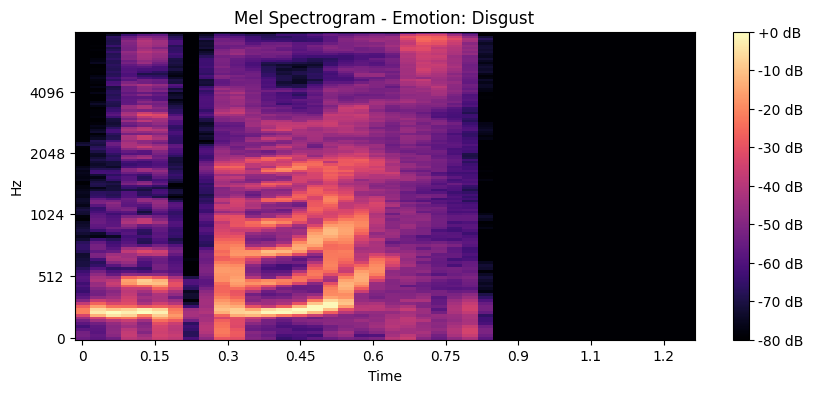

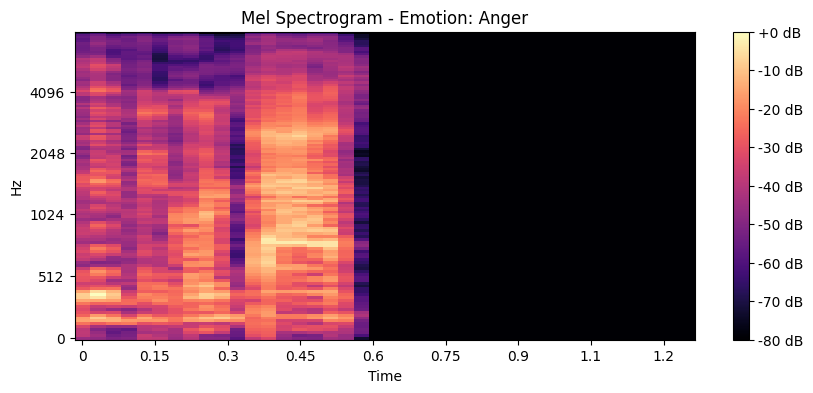

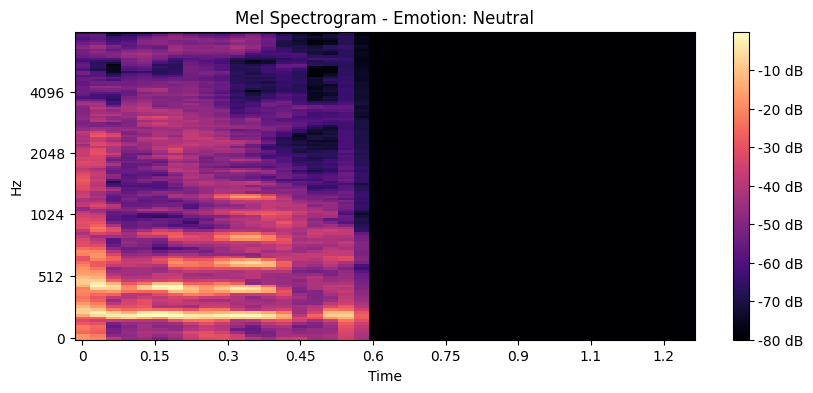

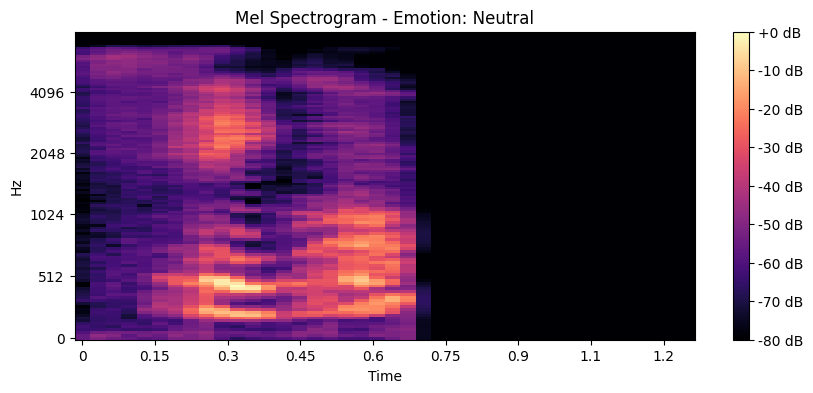

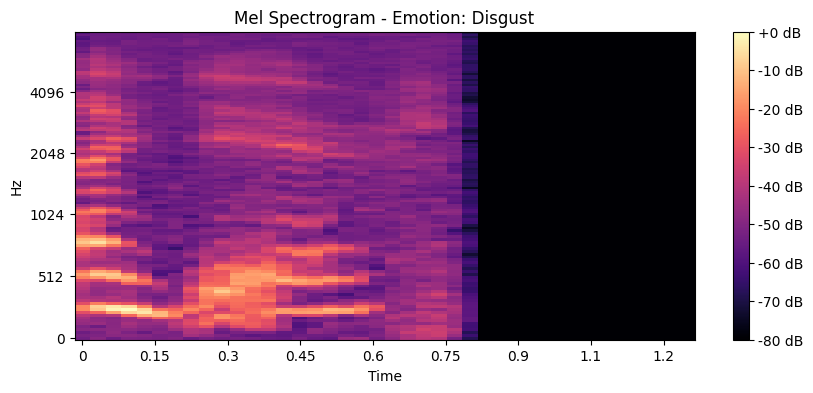

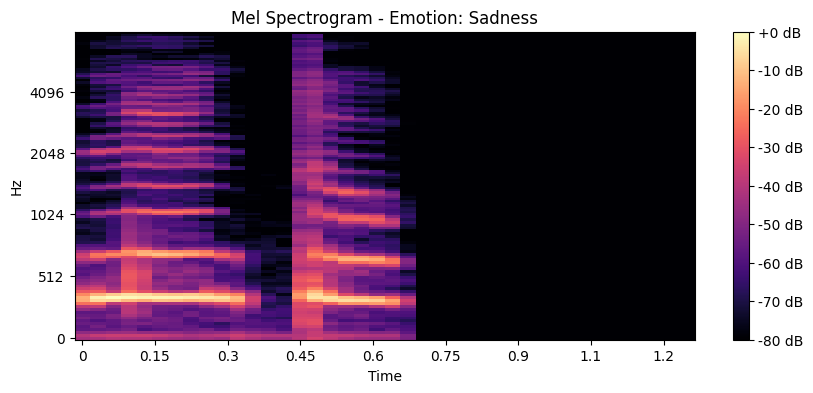

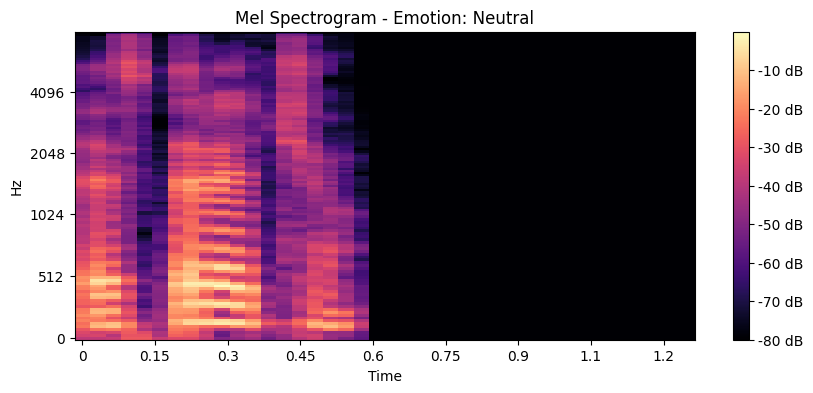

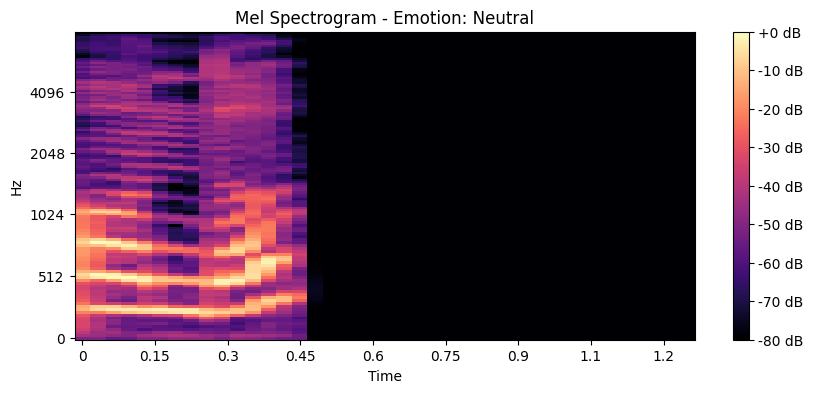

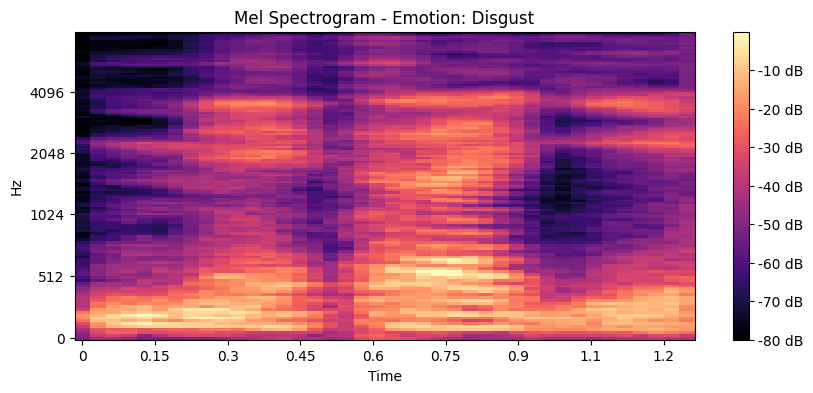

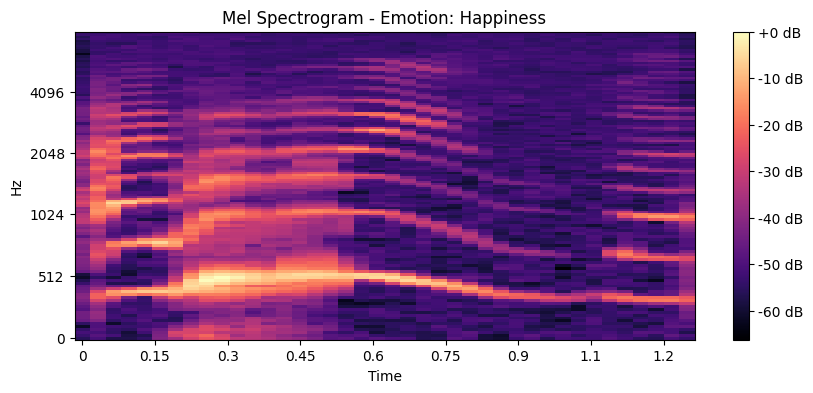

In [ ]:
display_random_samples_spectrogram(feature_space_2d_dataset,10)

### **Label encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(feature_space_2d_dataset['emotions'])
encoded_emotions = to_categorical(encoded_emotions,num_classes=6)
# Get original_labels = label_encoder.classes_
original_labels = label_encoder.classes_
print(len(encoded_emotions))
print(encoded_emotions)
print(original_labels)

1728
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
['Anger' 'Disgust' 'Fear' 'Happiness' 'Neutral' 'Sadness']


In [ ]:
from sklearn.model_selection import train_test_split
def split_data(x, encoded_emotion):
  # split the data into training and validation (70%) and testing (30%)
  X_train_val, X_test, y_train_val, y_test = train_test_split(
     x, encoded_emotions,
      test_size=0.1, random_state=42,stratify=encoded_emotions)
  # split the training and validation data into training and validation sets (95% and 5%)
  X_train, X_val, y_train, y_val = train_test_split(
      X_train_val, y_train_val, test_size=0.1, random_state=42,
      stratify=y_train_val)
  # convert the lists of features and labels to numpy arrays
  X_train = np.array(X_train)
  X_val = np.array(X_val)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  # print the shapes of the datasets
  print("Training data shape:", X_train.shape)
  print("Validation data shape:", X_val.shape)
  print("Testing data shape:", X_test.shape)
  print("Training labels shape:", y_train.shape)
  print("Validation labels shape:", y_val.shape)
  print("Testing labels shape:", y_test.shape)
  return X_train,X_val,X_test,y_train,y_val,y_test

In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = split_data(np.arange(0, len(encoded_emotions), 1), encoded_emotions)


Training data shape: (1399,)
Validation data shape: (156,)
Testing data shape: (173,)
Training labels shape: (1399, 6)
Validation labels shape: (156, 6)
Testing labels shape: (173, 6)


# **Modelos CNN 2D-LSTM**

In [ ]:
feature_2D = np.array(feature_space_2d_dataset["mel_spectrogram"])
X_train_2D = feature_2D[X_train,:,:]
X_valid_2D = feature_2D[X_valid,:]
X_test_2D = feature_2D[X_test,:]
y_train_2D = y_train
y_valid_2D = y_valid
y_test_2D = y_test

In [ ]:
print(X_train_2D.shape)
print(X_test_2D.shape)

(1399, 128, 40)
(173, 128, 40)


In [ ]:
X_train_m1 = X_train_2D
X_valid_m1 = X_valid_2D
X_test_m1 = X_test_2D
y_train_m1 = y_train_2D
y_valid_m1 = y_valid_2D
y_test_m1 = y_test_2D

## **Modelo V1**
---
Simple

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def build_2D_model1(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, epochs, verbose) :
    X_train_2D = np.reshape(X_train_2D, (X_train_2D.shape[0], X_train_2D.shape[1], X_train_2D.shape[2], 1))
    input_shape_2D = X_train_2D[0].shape

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=7, activation='relu', input_shape=input_shape_2D))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-4,
                            patience=5, verbose=1, mode='auto',
                            restore_best_weights=True)

    model.fit(X_train_2D, y_train_2D, epochs=epochs, verbose=verbose, validation_data=(X_valid_2D, y_valid_2D), callbacks=[monitor])
    return model

In [ ]:
model1 = build_2D_model1(X_train_m1,X_valid_m1,y_train_m1,y_valid_m1, 30, 1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 122, 34, 32)       1600      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 61, 17, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 61, 17, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 59, 15, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 29, 7, 64)         0         
 ng2D)                                                           
                                                      

In [ ]:
predicted_emotions_2D_ = model1.predict(X_test_m1)

6/6 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def calculate_accuracy(predicted_emotions, true_emotions):
  # Get the predicted classes and true classes
  predicted_classes = np.argmax(predicted_emotions, axis=1)
  true_classes = np.argmax(true_emotions, axis=1)

  # Calculate the accuracy
  accuracy = accuracy_score(true_classes, predicted_classes)

  # Calculate the F1-score
  f1 = f1_score(true_classes, predicted_classes, average='weighted')

  # Create the confusion matrix
  confusion = confusion_matrix(true_classes, predicted_classes)

  return accuracy*100,f1,confusion

In [ ]:
accuracy_model1,f1_model1,confusion_model1 = calculate_accuracy(predicted_emotions_2D_,y_test_m1)

In [ ]:
print(f"test accuracy 2D: {accuracy_model1}")
print(f"test f1_score 2D: {f1_model1}")
print("confusion matrix for model1 test data")
print(confusion_model1)

test accuracy 2D: 72.83236994219652
test f1_score 2D: 0.7279819235289395
confusion matrix for model1 test data
[[27  0  0  2  0  0]
 [ 3 19  1  4  1  1]
 [ 1  2 16  9  0  1]
 [ 4  1  1 21  1  1]
 [ 3  2  1  0 22  1]
 [ 1  0  4  1  1 21]]


### **Modelo V2**
---

In [ ]:
X_train_m2 = X_train_2D
X_valid_m2 = X_valid_2D
X_test_m2 = X_test_2D
y_train_m2 = y_train_2D
y_valid_m2 = y_valid_2D
y_test_m2 = y_test_2D

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def build_2D_model2(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, epochs, verbose) :
    X_train_2D = np.reshape(X_train_2D, (X_train_2D.shape[0], X_train_2D.shape[1], X_train_2D.shape[2], 1))
    input_shape_2D = X_train_2D[0].shape

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=7, activation='relu', input_shape=input_shape_2D))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-4,
                            patience=5, verbose=1, mode='auto',
                            restore_best_weights=True)

    model.fit(X_train_2D, y_train_2D, epochs=epochs, verbose=verbose, validation_data=(X_valid_2D, y_valid_2D), callbacks=[monitor])
    return model

In [ ]:
model2 = build_2D_model2(X_train_m2, X_valid_m2, y_train_m2, y_valid_m2, 30, 1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 122, 34, 32)       1600      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 61, 17, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_5 (Bat  (None, 61, 17, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 59, 15, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 29, 7, 64)         0         
 ng2D)                                                           
                                                      

In [ ]:
predicted_emotions_2D_ = model2.predict(X_test_m2)

6/6 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def calculate_accuracy(predicted_emotions, true_emotions):
  # Get the predicted classes and true classes
  predicted_classes = np.argmax(predicted_emotions, axis=1)
  true_classes = np.argmax(true_emotions, axis=1)

  # Calculate the accuracy
  accuracy = accuracy_score(true_classes, predicted_classes)

  # Calculate the F1-score
  f1 = f1_score(true_classes, predicted_classes, average='weighted')

  # Create the confusion matrix
  confusion = confusion_matrix(true_classes, predicted_classes)

  return accuracy*100,f1,confusion

In [ ]:
accuracy_model2,f1_model2,confusion_model2 = calculate_accuracy(predicted_emotions_2D_,y_test_m2)

In [ ]:
print(f"test accuracy 2D: {accuracy_model2}")
print(f"test f1_score 2D: {f1_model2}")
print("confusion matrix for model1 test data")
print(confusion_model2)

test accuracy 2D: 88.4393063583815
test f1_score 2D: 0.8842535789022573
confusion matrix for model1 test data
[[28  0  0  0  1  0]
 [ 2 26  0  0  0  1]
 [ 1  1 24  0  0  3]
 [ 1  0  0 26  2  0]
 [ 1  0  1  0 27  0]
 [ 0  1  3  0  2 22]]


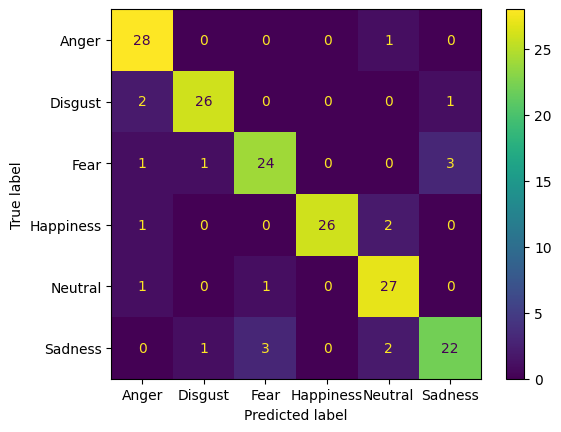

In [ ]:
cm_display_2D_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_model2, display_labels = original_labels)
cm_display_2D_.plot()
plt.show()

## **Modelo V3**
---

In [ ]:
X_train_m3 = X_train_2D
X_valid_m3 = X_valid_2D
X_test_m3 = X_test_2D
y_train_m3 = y_train_2D
y_valid_m3 = y_valid_2D
y_test_m3 = y_test_2D

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def build_2D_model3(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, epochs, verbose) :
    X_train_2D = np.reshape(X_train_2D, (X_train_2D.shape[0], X_train_2D.shape[1], X_train_2D.shape[2], 1))
    input_shape_2D = X_train_2D[0].shape

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape_2D))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-4,
                            patience=5, verbose=1, mode='auto',
                            restore_best_weights=True)

    model.fit(X_train_2D, y_train_2D, epochs=epochs, verbose=verbose, validation_data=(X_valid_2D, y_valid_2D), callbacks=[monitor])
    return model

In [ ]:
model3 = build_2D_model3(X_train_m3, X_valid_m3,y_train_m3, y_valid_m3, 30, 1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 124, 36, 32)       832       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 62, 18, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_6 (Bat  (None, 62, 18, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 62, 18, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 16, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 8, 64)        

In [ ]:
predicted_emotions_2D_ = model3.predict(X_test_m3)

6/6 [==============================] - 0s 51ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def calculate_accuracy(predicted_emotions, true_emotions):
  # Get the predicted classes and true classes
  predicted_classes = np.argmax(predicted_emotions, axis=1)
  true_classes = np.argmax(true_emotions, axis=1)

  # Calculate the accuracy
  accuracy = accuracy_score(true_classes, predicted_classes)

  # Calculate the F1-score
  f1 = f1_score(true_classes, predicted_classes, average='weighted')

  # Create the confusion matrix
  confusion = confusion_matrix(true_classes, predicted_classes)

  return accuracy*100,f1,confusion

In [ ]:
accuracy_model3,f1_model3,confusion_model3 = calculate_accuracy(predicted_emotions_2D_,y_test_m3)

In [ ]:
print(f"test accuracy 2D: {accuracy_model3}")
print(f"test f1_score 2D: {f1_model3}")
print("confusion matrix for model1 test data")
print(confusion_model3)

test accuracy 2D: 78.61271676300578
test f1_score 2D: 0.7875439630354771
confusion matrix for model1 test data
[[25  0  1  0  2  1]
 [ 1 15  4  0  8  1]
 [ 0  0 21  0  3  5]
 [ 0  0  2 22  5  0]
 [ 0  0  1  0 27  1]
 [ 0  0  0  0  2 26]]


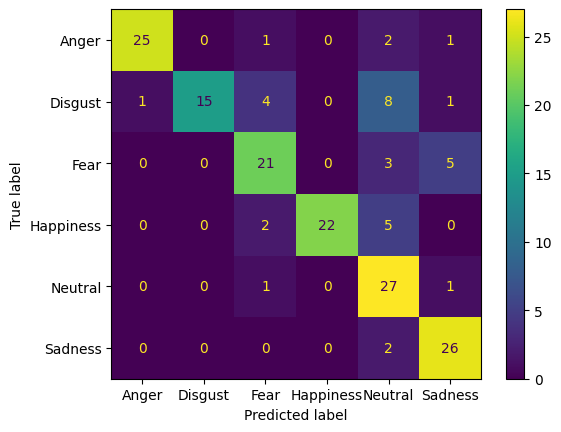

In [ ]:
cm_display_2D_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_model3, display_labels = original_labels)
cm_display_2D_.plot()
plt.show()

### **Obtenemos el mejor modelo**

In [ ]:
print(f"Test accuracy model1: {accuracy_model1}")
print(f"Test accuracy model2: {accuracy_model2}")
print(f"Test accuracy model3: {accuracy_model3}")

Test accuracy model1: 72.83236994219652
Test accuracy model2: 88.4393063583815
Test accuracy model3: 78.61271676300578


### **Guardamos el modelo 2d**

In [ ]:
keras.saving.save_model(model2, '/content/drive/MyDrive/model2_cnn2d.h5')